<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/GoodShakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
text = requests.get(url)

In [141]:
import random

In [142]:
text = text.text

In [143]:
text = text.lower()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for ele in punc:
  if ele in text:
    text = text.replace(ele, "")

In [144]:
vocab = text.split()

In [145]:
vocab_dict = set()
for word in vocab:
  if random.randint(1, 100) > 50:
    vocab_dict.update([word])

In [146]:
len(vocab_dict)

9199

In [147]:
vocab_dict = sorted(vocab_dict)

In [148]:
stoi = {"[PAD]": 0, "[UNK]": 1}
itos = {0: "[PAD]", 1: "[UNK]"}
stoi.update({char:i+2 for i, char in enumerate(vocab_dict)})
itos.update({i+2:char for i, char in enumerate(vocab_dict)})

In [149]:
stoi['a']

3

In [150]:
itos[stoi['a']]

'a'

In [151]:
class Tokenizer:
  def __init__(self, stoi, itos, len=10):
    self.stoi = stoi
    self.itos = itos
    self.len = len
  def encode(self, text, crop=True, pad=True):
    out = []
    if crop:
      for word in text.lower().split()[:self.len]:
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
    else:
      for word in text.lower().split():
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
  def decode(self, ids):
    out = ""
    for id in ids:
      if (id in self.itos) and id != 1:
        out += self.itos[id] + " "
      elif id==0:
        out += '[PAD]'
      else:
        out += '[UNK] '
    return out

In [152]:
tokenizer = Tokenizer(stoi, itos)

In [153]:
tokenizer.encode("hello world", pad=False)

[1, 9086]

In [154]:
tokenizer.decode(tokenizer.encode("hello world", pad=False))

'[UNK] world '

In [155]:
import torch

In [156]:
import torch.nn.functional as F

In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [158]:
num_epochs = 100000
lr = 100
batch_size = 256

In [159]:
context_len = 3
emb_dim = 20
vocab_size = len(stoi)
n_hidden = 400
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) * 0.1
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, vocab_size).to(device) * 0.1
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

tokenizer = Tokenizer(stoi, itos, len=context_len)

In [160]:
def build_dataset(text):
  xs = []
  ys = []
  tokenized_text = tokenizer.encode(text, crop=False)
  context = [0] * (context_len)
  for x in tokenized_text:
    xs.append(context)
    ys.append(x)
    context = context[1:] + [x]
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys
Xtr, Ytr = build_dataset(text)
train_examples = len(Xtr) - 1

In [161]:
epochs = []
losses = []

In [162]:
for epoch in range(num_epochs):
  batch_indices = torch.randint(0, train_examples, (batch_size, ))
  xs = Xtr[batch_indices]
  ys = Ytr[batch_indices]
  emb = C[xs].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  logits = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(logits, ys)
  epochs.append(epoch)
  losses.append(loss.item())

  for p in params:
    p.grad = None

  loss.backward()

  for p in params:
    p.data -= p.grad * (lr * ((epoch+1) ** -0.5))

  if epoch % 10000 == 0:
    print("Epoch", str(epoch) + ", loss:", loss.item())


    print(tokenizer.decode(xs[0].cpu().numpy()))
    print(tokenizer.decode([ys[0].cpu().item()]))
    selected = [logits.softmax(dim=1)[0].argmax().item()]
    print("Predicted index:", selected)
    print("Predicted word:", tokenizer.decode(selected))
    print(logits.softmax(dim=1)[0].argmax(), logits.shape)
    print("Confidence:", logits.softmax(dim=1)[0][logits.softmax(dim=1)[0].argmax()])

Epoch 0, loss: 9.347589492797852
he escape post 
he 
Predicted index: [1151]
Predicted word: camest 
tensor(1151, device='cuda:0') torch.Size([256, 9201])
Confidence: tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
Epoch 10000, loss: 7.801671028137207
awake takes note 
of 
Predicted index: [1]
Predicted word: [UNK] 
tensor(1, device='cuda:0') torch.Size([256, 9201])
Confidence: tensor(0.0006, device='cuda:0', grad_fn=<SelectBackward0>)
Epoch 20000, loss: 7.736669540405273
knees to me 
to 
Predicted index: [1]
Predicted word: [UNK] 
tensor(1, device='cuda:0') torch.Size([256, 9201])
Confidence: tensor(0.0006, device='cuda:0', grad_fn=<SelectBackward0>)
Epoch 30000, loss: 7.7094926834106445
would have stirrd 
up 
Predicted index: [1]
Predicted word: [UNK] 
tensor(1, device='cuda:0') torch.Size([256, 9201])
Confidence: tensor(0.0006, device='cuda:0', grad_fn=<SelectBackward0>)
Epoch 40000, loss: 7.679647445678711
brave fellow but 
hes 
Predicted index: [1]
Predicted word: [UNK]

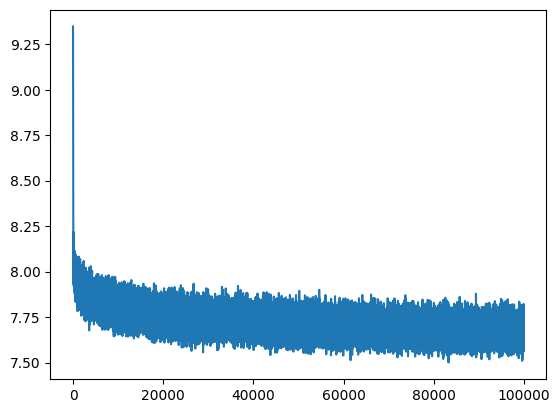

In [163]:
import matplotlib.pyplot as plt

plt.plot(epochs, losses)

In [164]:
Xtr[100]

tensor([3962, 7992, 9109], device='cuda:0')

In [165]:
Ytr[100]

tensor(9165, device='cuda:0')

In [166]:
tokenizer.decode([Ytr[100].cpu().numpy().item()])

'yield '

In [167]:
tokenizer.decode(Xtr[100].cpu().numpy())

'if they would '

In [168]:
def prompt(text, len=10):
  with torch.no_grad():
    output = text + " "
    for x in range(len):
      xs = torch.tensor(tokenizer.encode(output)).to(device)
      emb = C[xs].view(-1, emb_dim * context_len)
      l1 = (emb @ w1 + b1).tanh()
      logits = (l1 @ w2 + b2).tanh()
      outs = logits.softmax(dim=1)[0]
      #selected = torch.multinomial(outs, num_samples=1).cpu().numpy()
      selected = [outs.argmax().item()]
      outchar = tokenizer.decode(selected)
      output += outchar
    return output

In [169]:
prompt("")

' [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] '

In [170]:
def get_likelihood(input, expected):
  with torch.no_grad():
    emb = C[input].view(-1, emb_dim * context_len)
    l1 = (emb @ w1 + b1).tanh()
    logits = (l1 @ w2 + b2).tanh()
    outs = logits.softmax(dim=1)
    print(outs.shape)
    print("Max:", outs[0].argmax(), outs[0][outs.argmax()])
    return outs[0][expected]

In [171]:
get_likelihood(Xtr[100], Ytr[100])

torch.Size([1, 9201])
Max: tensor(1, device='cuda:0') tensor(0.0007, device='cuda:0')


tensor(9.0942e-05, device='cuda:0')

In [172]:
prompt("romeo")

'romeo [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] '

In [173]:
prompt(tokenizer.decode(Xtr[100].cpu().numpy()))

'if they would  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] '

In [174]:
prompt("which", len=100)

'which [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] '

In [175]:
def random_prompt(text, len=10):
  with torch.no_grad():
    output = text + " "
    for x in range(len):
      xs = torch.tensor(tokenizer.encode(output)).to(device)
      emb = C[xs].view(-1, emb_dim * context_len)
      l1 = (emb @ w1 + b1).tanh()
      logits = (l1 @ w2 + b2).tanh()
      logits = torch.ones(logits.shape)
      outs = logits.softmax(dim=1)
      selected = torch.multinomial(outs, num_samples=1)[0].cpu().numpy()
      outchar = tokenizer.decode(selected)
      output += outchar
    return output

In [176]:
random_prompt("", len=100)

' quailing camel strangled dishonest badness overtake innocence hercules buckinghams inauspicious lightning paramour rebels companions thracian cowards grandam lineal shapes rivers vouches severely sleepy infected cipher committed worm perdition chasing epitome willt morecast 3 slandering committing transport reveal troth visor nobleness monument wilderness commend blunt sparks greybeard scolding thin richest no corners flote dear relieved deceitful flung quote basest carried ground nineteen atlas shrugst prefixd merriest batten maintain dispatchd nimbly newbuilt barren avoided spell courageous givet fruittrees follies calls horrible uprighteously politic conscience conversation finder hearkening money ache lineaments restorative common sacred champion meteor unhappily horsemen carefully francisco fines decay gash '

random is better